In [1]:
import pandas as pd
import optuna

In [2]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.svm import OneClassSVM
from sklearn.neighbors import KDTree, BallTree
import pandas as pd
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
)


class DBOCSVM:
    def __init__(
        self,
        kernel="rbf",
        degree=3,
        gamma="scale",
        coef0=0.0,
        tol=0.001,
        nu=0.5,
        shrinking=True,
        cache_size=200,
        verbose=False,
        max_iter=-1,
        eps=0.5,
        min_samples=10,
        tree_metric="euclidean",
        dbscan_metric="euclidean",
        algorithm="kd_tree",  # or 'ball_tree'
        leaf_size=30,
        n_jobs=-1,  # Add n_jobs parameter
    ):
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        self.coef0 = coef0
        self.tol = tol
        self.nu = nu
        self.shrinking = shrinking
        self.cache_size = cache_size
        self.verbose = verbose
        self.max_iter = max_iter
        self.algorithm = algorithm
        self.leaf_size = leaf_size
        self.tree_metric = tree_metric
        self.dbscan_metric = dbscan_metric
        self.dbscan = DBSCAN(
            eps=eps, min_samples=min_samples, n_jobs=n_jobs, metric=dbscan_metric
        )  # Make it so that it can accept a metric parameter
        self.svms = {}  # One SVM per cluster
        self.dbscan_centroids = {}  # To store cluster centroids
        self.cluster_points = {}  # Store points in each cluster
        self.tree = None
        # These attributes are mainly used for inspection purposes
        self.cluster_sizes = {}  # Number of points in each cluster
        self.n_jobs = n_jobs  # Store n_jobs
        self.cluster_labels = None
        self.unique_clusters = None

    def fit_cluster(
        self,
        X,
        dbscan_evaluation_metric="silhouette",
        dbscan_rerun=False,
        dbscan_rerun_trials=10,
        verbose=False,
    ):
        """
        Parameters:
        -----------
        X : array-like
            Training data
        dbscan_evaluation_metric : str
            Metric to optimize ('silhouette', 'davies_bouldin', or 'calinski_harabasz')
        dbscan_rerun : bool
            Whether to rerun DBSCAN after fitting the model with the best parameters
        dbscan_rerun_trials : int
            Number of reruns for DBSCAN after fitting the model with the best parameters
        """

        X = X.values if isinstance(X, pd.DataFrame) else X

        """
        NOTE: Current DBSCAN only uses euclidean distance, so the metric parameter is not used
        TODO: Add metric parameter to DBSCAN to handle different distance metrics
        'euclidean': Standard Euclidean distance. This is the default metric.
        'manhattan': Manhattan or L1 distance (sum of absolute differences).
        'chebyshev': Chebyshev or maximum distance.
        'minkowski': Minkowski distance, a generalization of Euclidean and Manhattan distance. The power parameter p of the Minkowski metric can be controlled by the p parameter of DBSCAN.
        'wminkowski': Weighted Minkowski distance.
        'seuclidean': Standardized Euclidean distance.
        'mahalanobis': Mahalanobis distance.
        """
        self.cluster_labels = self.dbscan.fit_predict(X)

        if dbscan_rerun:
            if dbscan_evaluation_metric == "silhouette":
                current_score = silhouette_score(X, self.cluster_labels)
            elif dbscan_evaluation_metric == "davies_bouldin":
                current_score = davies_bouldin_score(X, self.cluster_labels)
            else:  # calinski_harabasz
                current_score = calinski_harabasz_score(X, self.cluster_labels)

            for i in range(dbscan_rerun_trials):
                new_cluster_labels = self.dbscan.fit_predict(X)

                if dbscan_evaluation_metric == "silhouette":
                    new_score = silhouette_score(X, new_cluster_labels)
                    if new_score > current_score:
                        self.cluster_labels = new_cluster_labels
                        current_score = new_score
                elif dbscan_evaluation_metric == "davies_bouldin":
                    new_score = davies_bouldin_score(X, new_cluster_labels)
                    if new_score < current_score:
                        self.cluster_labels = new_cluster_labels
                        current_score = new_score
                else:  # calinski_harabasz
                    new_score = calinski_harabasz_score(X, new_cluster_labels)
                    if new_score > current_score:
                        self.cluster_labels = new_cluster_labels
                        current_score = new_score

        self.unique_clusters = np.unique(self.cluster_labels)

        if verbose:
            print(f"Unique Clusters: {self.unique_clusters}")

        for cluster in self.unique_clusters:
            # Store the number of points in the cluster
            # mainly for inspection purposes
            n_points = np.sum(self.cluster_labels == cluster)
            self.cluster_sizes[int(cluster)] = int(n_points)

        if verbose:
            print(f"Cluster Sizes: {self.cluster_sizes}")

    def fit_ocsvm(
        self,
        X,
        parameter_list=None,
        verbose=False,
    ):
        """
        Parameters:
        -----------
        X : array-like
            Training data
        parameter_list: dictionary of dictionaries
            Each key in the dictionary is the cluster number and
            the value is a dictionary containing the parameters for OCSVM
            each dictionary looks like this:
            {
                0 : {
                kernel: rbf, linear, poly, or sigmoid,
                gamma: 'scale', 'auto' or a float,
                nu: a float between 0 and 1 e.g 0.2,
                }
            }
        """
        X = X.values if isinstance(X, pd.DataFrame) else X

        if parameter_list is None:
            raise ValueError("parameter_list cannot be None")

        if len(self.unique_clusters) - 1 != len(parameter_list):
            raise ValueError(
                "Number of parameters should be equal to the number of clusters"
            )

        for cluster in self.unique_clusters:

            if cluster == -1:  # Skip noise cluster for SVM training
                continue

            if verbose:
                print(
                    f"Training for cluster {cluster} with {self.cluster_sizes[cluster]} points"
                )

            """
            Boolean masking to get points in the current cluster
            """
            points = X[self.cluster_labels == cluster]
            self.cluster_points[cluster] = points

            if len(points) > 0:
                """
                NOTE: each cluster is trained with a OneClassSVM with the same parameters
                TODO: write function to handle and optimize different parameters for each cluster
                NOTE: Instead of doing the tuning here we can use Optuna to optimize the parameters on the DBOCSVM itself by
                passing parameters for the values to be optimized
                - 1. after clustering we now know the number of clusters
                - 2. we can now optimize each OCSVM by passing an array of arrays, in which each inner array contains the parameters
                and the length of the outer array is the number of clusters
                - 3. we can then use optuna to optimize the parameters for each cluster
                - 4. separate the optimization of the DBSCAN and the OCSVM, so that the DBSCAN is optimized first and then the OCSVM
                - 5. create fit_cluster to cluster first then fit_ocsvm to fit the OCSVM after the clusters have formed
                """
                ocsvm = OneClassSVM(
                    kernel=parameter_list[cluster]["kernel"],
                    nu=parameter_list[cluster]["nu"],
                    gamma=parameter_list[cluster]["gamma"],
                    degree=self.degree,
                    coef0=self.coef0,
                    tol=self.tol,
                    shrinking=self.shrinking,
                    cache_size=self.cache_size,
                    verbose=self.verbose,
                    max_iter=self.max_iter,
                )
                ocsvm.fit(points)
                self.svms[cluster] = ocsvm

                """
                TODO: Explore other alternatives for centroid calculation
                "->" means the following line might be a downside of the current approach.
                
                - Median: More robust to outliers than the mean (`np.median(points, axis=0)`).
                    -> Less representative if data is asymmetric  
                - Trimmed Mean: Removes extreme values before computing the mean (`scipy.stats.trim_mean`).
                    ->   Requires choosing the trimming percentage
                - Weighted Mean: Assigns importance to points based on reliability.  
                    ->  Requires defining weights
                - Geometric Median: Minimizes sum of distances to all points. More robust to outliers than the mean.
                    -> computationally expensive (`scipy.spatial`)
                - Distance Metrics: Use median for Manhattan distance and mean for Euclidean distance.
                    -> Requires choosing the distance metric
                    
                """
                self.dbscan_centroids[cluster] = np.mean(points, axis=0)

        # Build tree with cluster centroids
        centroids = [self.dbscan_centroids[c] for c in self.dbscan_centroids if c != -1]
        self.valid_clusters = list(self.dbscan_centroids.keys())
        if len(centroids) > 0:
            centroids = np.array(centroids)
            if self.algorithm == "kd_tree":
                self.tree = KDTree(
                    centroids, leaf_size=self.leaf_size, metric=self.tree_metric
                )
            elif self.algorithm == "ball_tree":
                self.tree = BallTree(
                    centroids, leaf_size=self.leaf_size, metric=self.tree_metric
                )

    def fit(
        self,
        X,
        dbscan_evaluation_metric="silhouette",
        dbscan_rerun=False,
        dbscan_rerun_trials=10,
        parameter_list=None,
        verbose=False,
    ):
        """
        Parameters:
        -----------
        X : array-like
            Training data
        dbscan_evaluation_metric : str
            Metric to optimize ('silhouette', 'davies_bouldin', or 'calinski_harabasz')
        dbscan_rerun : bool
            Whether to rerun DBSCAN after fitting the model with the best parameters
        dbscan_rerun_trials : int
            Number of reruns for DBSCAN after fitting the model with the best parameters
        parameter_list: dictionary of dictionaries
            Each key in the dictionary is the cluster number and
            the value is a dictionary containing the parameters for OCSVM
            each dictionary looks like this:
            {
                0 : {
                kernel: rbf, linear, poly, or sigmoid,
                gamma: 'scale', 'auto' or a float,
                nu: a float between 0 and 1 e.g 0.2,
                }
            }
        """

        X = X.values if isinstance(X, pd.DataFrame) else X

        """
        NOTE: Current DBSCAN only uses euclidean distance, so the metric parameter is not used
        TODO: Add metric parameter to DBSCAN to handle different distance metrics
        'euclidean': Standard Euclidean distance. This is the default metric.
        'manhattan': Manhattan or L1 distance (sum of absolute differences).
        'chebyshev': Chebyshev or maximum distance.
        'minkowski': Minkowski distance, a generalization of Euclidean and Manhattan distance. The power parameter p of the Minkowski metric can be controlled by the p parameter of DBSCAN.
        'wminkowski': Weighted Minkowski distance.
        'seuclidean': Standardized Euclidean distance.
        'mahalanobis': Mahalanobis distance.
        """
        cluster_labels = self.dbscan.fit_predict(X)

        if dbscan_rerun:
            if dbscan_evaluation_metric == "silhouette":
                current_score = silhouette_score(X, cluster_labels)
            elif dbscan_evaluation_metric == "davies_bouldin":
                current_score = davies_bouldin_score(X, cluster_labels)
            else:  # calinski_harabasz
                current_score = calinski_harabasz_score(X, cluster_labels)

            for i in range(dbscan_rerun_trials):
                new_cluster_labels = self.dbscan.fit_predict(X)

                if dbscan_evaluation_metric == "silhouette":
                    new_score = silhouette_score(X, new_cluster_labels)
                    if new_score > current_score:
                        cluster_labels = new_cluster_labels
                        current_score = new_score
                elif dbscan_evaluation_metric == "davies_bouldin":
                    new_score = davies_bouldin_score(X, new_cluster_labels)
                    if new_score < current_score:
                        cluster_labels = new_cluster_labels
                        current_score = new_score
                else:  # calinski_harabasz
                    new_score = calinski_harabasz_score(X, new_cluster_labels)
                    if new_score > current_score:
                        cluster_labels = new_cluster_labels
                        current_score = new_score

        unique_clusters = np.unique(cluster_labels)

        if verbose:
            print(f"Unique Clusters: {self.unique_clusters}")

        for cluster in unique_clusters:
            # Store the number of points in the cluster
            # mainly for inspection purposes
            n_points = np.sum(cluster_labels == cluster)
            self.cluster_sizes[int(cluster)] = int(n_points)

        if verbose:
            print(f"Cluster Sizes: {self.cluster_sizes}")

        if parameter_list is not None and (len(unique_clusters) - 1) != len(
            parameter_list
        ):
            raise ValueError(
                "parameter_list should be the same length as the number of clusters"
            )

        for cluster in unique_clusters:

            # Store the number of points in the cluster
            # n_points = np.sum(cluster_labels == cluster)
            # self.cluster_sizes[int(cluster)] = int(n_points)

            if cluster == -1:  # Skip noise cluster for SVM training
                continue

            if verbose:
                print(
                    f"Training for cluster {cluster} with {self.cluster_sizes[cluster]} points"
                )

            """
            Boolean masking to get points in the current cluster
            """
            points = X[cluster_labels == cluster]
            self.cluster_points[cluster] = points

            if len(points) > 0:
                """
                NOTE: each cluster is trained with a OneClassSVM with the same parameters
                TODO: write function to handle and optimize different parameters for each cluster
                NOTE: Instead of doing the tuning here we can use Optuna to optimize the parameters on the DBOCSVM itself by
                passing parameters for the values to be optimized
                - 1. after clustering we now know the number of clusters
                - 2. we can now optimize each OCSVM by passing an array of arrays, in which each inner array contains the parameters
                and the length of the outer array is the number of clusters
                - 3. we can then use optuna to optimize the parameters for each cluster
                - 4. separate the optimization of the DBSCAN and the OCSVM, so that the DBSCAN is optimized first and then the OCSVM
                - 5. create fit_cluster to cluster first then fit_ocsvm to fit the OCSVM after the clusters have formed
                """
                if parameter_list is None:
                    ocsvm = OneClassSVM(
                        kernel=self.kernel,
                        nu=self.nu,
                        gamma=self.gamma,
                        degree=self.degree,
                        coef0=self.coef0,
                        tol=self.tol,
                        shrinking=self.shrinking,
                        cache_size=self.cache_size,
                        verbose=self.verbose,
                        max_iter=self.max_iter,
                    )
                else:
                    ocsvm = OneClassSVM(
                        kernel=parameter_list[cluster]["kernel"],
                        nu=parameter_list[cluster]["nu"],
                        gamma=parameter_list[cluster]["gamma"],
                        degree=self.degree,
                        coef0=self.coef0,
                        tol=self.tol,
                        shrinking=self.shrinking,
                        cache_size=self.cache_size,
                        verbose=self.verbose,
                        max_iter=self.max_iter,
                    )
                    print(
                        f"OCSVM for cluster {cluster} uses nu: {parameter_list[cluster]['nu']}"
                    )
                    print(
                        f"OCSVM for cluster {cluster} uses gamma: {parameter_list[cluster]['gamma']}"
                    )
                ocsvm.fit(points)

                print("<-------------------------------------------->")
                self.svms[cluster] = ocsvm

                """
                TODO: Explore other alternatives for centroid calculation
                "->" means the following line might be a downside of the current approach.
                
                - Median: More robust to outliers than the mean (`np.median(points, axis=0)`).
                    -> Less representative if data is asymmetric  
                - Trimmed Mean: Removes extreme values before computing the mean (`scipy.stats.trim_mean`).
                    ->   Requires choosing the trimming percentage
                - Weighted Mean: Assigns importance to points based on reliability.  
                    ->  Requires defining weights
                - Geometric Median: Minimizes sum of distances to all points. More robust to outliers than the mean.
                    -> computationally expensive (`scipy.spatial`)
                - Distance Metrics: Use median for Manhattan distance and mean for Euclidean distance.
                    -> Requires choosing the distance metric
                    
                """
                self.dbscan_centroids[cluster] = np.mean(points, axis=0)

        # Build tree with cluster centroids
        centroids = [self.dbscan_centroids[c] for c in self.dbscan_centroids if c != -1]
        self.valid_clusters = list(self.dbscan_centroids.keys())
        if len(centroids) > 0:
            centroids = np.array(centroids)
            if self.algorithm == "kd_tree":
                self.tree = KDTree(
                    centroids, leaf_size=self.leaf_size, metric=self.tree_metric
                )
            elif self.algorithm == "ball_tree":
                self.tree = BallTree(
                    centroids, leaf_size=self.leaf_size, metric=self.tree_metric
                )

    def predict(self, X):
        predictions = np.ones(len(X))
        X = X.values if isinstance(X, pd.DataFrame) else X

        if self.tree is None:
            return -1 * np.ones(len(X))

        # Find nearest centroid
        dist, ind = self.tree.query(X, k=1)
        nearest_clusters = [self.valid_clusters[i] for i in ind.flatten()]

        for i, cluster in enumerate(nearest_clusters):
            if cluster in self.svms:
                predictions[i] = self.svms[cluster].predict([X[i]])[0]
            else:
                predictions[i] = -1  # Anomaly if no SVM for cluster

        return predictions


"""
Classification Report on NSL-KDD:
              precision    recall  f1-score   support

     Anomaly       0.57      1.00      0.73     12832
      Normal       1.00      0.00      0.00      9711

    accuracy                           0.57     22543
   macro avg       0.78      0.50      0.36     22543
weighted avg       0.75      0.57      0.41     22543

Precision: 0.5693495429940545
Recall: 1.0
F1 Score: 0.7255866553576478
"""

"""
Tuning on the validation set results in extreme overfitting
Model performs better but only on the validation set, the test set results are worse
Cannot use the full train set since it crashed the kernel
TODO: Implement a better tuning strategy that generalizes well
TODO: Explore other preprocessing steps e.g Autoencoder, Min-Max Normalization, Feature Selection
"""


'\nTuning on the validation set results in extreme overfitting\nModel performs better but only on the validation set, the test set results are worse\nCannot use the full train set since it crashed the kernel\nTODO: Implement a better tuning strategy that generalizes well\nTODO: Explore other preprocessing steps e.g Autoencoder, Min-Max Normalization, Feature Selection\n'

# Training with full dataset

In [3]:
train_set_full_path = "datasets/train_set_full.csv"
train_dataset_full = pd.read_csv(train_set_full_path)
print(f"train set count: {train_dataset_full.shape[0]:,}")
train_dataset_full.head(3)

train set count: 67,342


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,-0.11025,-0.007737,-0.004919,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,-0.809267,-0.011664,...,-0.31289,-0.11205,-0.028606,-0.139983,-0.618441,-0.053906,-0.031768,-0.019726,0.825156,-0.046432
1,-0.11025,-0.007723,-0.002891,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,1.235686,-0.011664,...,-0.31289,-0.11205,-0.028606,-0.139983,-0.618441,-0.053906,-0.031768,-0.019726,0.825156,-0.046432
2,-0.11025,-0.007728,-0.004814,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,1.235686,-0.011664,...,-0.31289,-0.11205,-0.028606,-0.139983,-0.618441,-0.053906,-0.031768,-0.019726,0.825156,-0.046432


In [4]:
# train_dataset_full = train_dataset_full.sample(frac=0.48)
train_dataset_full = train_dataset_full
train_dataset_full.shape

(67342, 122)

In [5]:
ocsvm = DBOCSVM(
    kernel="rbf",
    gamma="auto",
    nu=0.2,
    eps=19.849059093092972,
    min_samples=47,
    algorithm="ball_tree",
)  # Adjust parameters as needed
print(ocsvm.n_jobs)

-1


In [6]:
# ocsvm.fit(train_dataset_full.values, parameter_list=parameter_list)
ocsvm.fit(train_dataset_full.values)

<-------------------------------------------->
<-------------------------------------------->
<-------------------------------------------->
<-------------------------------------------->
<-------------------------------------------->
<-------------------------------------------->
<-------------------------------------------->


# Testing

Preparing test set

In [7]:
test_set_path = "datasets/test_set.csv"

test_set = pd.read_csv(test_set_path)
print(f"test set count: {test_set.shape[0]:,}")

test set count: 22,543


In [8]:
test_set.head(3)

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,attack_binary,attack_categorical,attack_class
0,-0.110250,-0.007762,-0.004919,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,-0.809267,-0.011664,...,-0.139983,-0.618441,-0.053906,-0.031768,-0.019726,-1.211893,-0.046432,-1,neptune,DoS
1,-0.109482,-0.005551,-0.004919,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,-0.809267,-0.011664,...,-0.139983,-0.618441,-0.053906,-0.031768,-0.019726,0.825156,-0.046432,1,normal,normal
2,-0.110250,-0.007759,-0.004919,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,-0.809267,-0.011664,...,-0.139983,-0.618441,-0.053906,-0.031768,-0.019726,0.825156,-0.046432,-1,saint,Probe


In [9]:
X_test = test_set.drop(columns=["attack_binary", "attack_categorical", "attack_class"])

y_test = test_set["attack_binary"]
print(y_test.unique())

[-1  1]


Perform prediction

In [10]:
y_pred = ocsvm.predict(X_test.values)

In [11]:
print(*y_pred[:10], sep="\n")

-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0
1.0
-1.0
-1.0


In [12]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred, labels=[-1, 1])

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[11918   914]
 [ 2345  7366]]


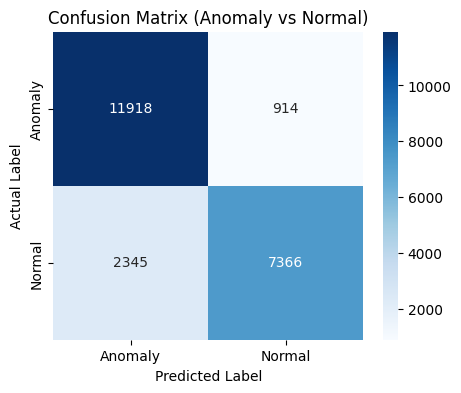

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title(title)
    plt.show()


plot_confusion_matrix(cm, ["Anomaly", "Normal"], "Confusion Matrix (Anomaly vs Normal)")

In [14]:
from sklearn.metrics import (
    classification_report,
    precision_score,
    recall_score,
    f1_score,
)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Anomaly", "Normal"]))

precision = precision_score(y_test, y_pred, pos_label=-1)
recall = recall_score(y_test, y_pred, pos_label=-1)
f1 = f1_score(y_test, y_pred, pos_label=-1)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Classification Report:
              precision    recall  f1-score   support

     Anomaly       0.84      0.93      0.88     12832
      Normal       0.89      0.76      0.82      9711

    accuracy                           0.86     22543
   macro avg       0.86      0.84      0.85     22543
weighted avg       0.86      0.86      0.85     22543

Precision: 0.8355885858515039
Recall: 0.9287718204488778
F1 Score: 0.8797195054438088
